<a href="https://colab.research.google.com/github/Lucs1590/USeS-BPCA/blob/main/notebooks/u_net_bpca.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U-net-like with Oxford-IIIT Pet Dataset

## Imports

In [70]:
import os
import time

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model
from keras.callbacks import (EarlyStopping, ModelCheckpoint, CSVLogger)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds


In [44]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

if 'content' in os.getcwd():
    COLAB = True
    from google.colab import drive
    drive.mount('/content/gdrive')
    RESOURCES_DIR = f'{os.path.join(os.getcwd(), os.pardir)}/resources/'
else:
    RESOURCES_DIR = f'{(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))}/resources/'

np.random.seed(77)
tf.random.set_seed(77)


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Constant Variables

In [45]:
RESOURCES_DIR = RESOURCES_DIR.replace('..', '').replace('//', '/')
None if os.path.isdir(RESOURCES_DIR) else os.mkdir(RESOURCES_DIR)
MODEL_NAME = 'raw_unet'

BATCH_SIZE = 64
BUFFER_SIZE = 1000
HEIGHT, WIDTH = 256, 256
NUM_CLASSES = 3  # background, foreground, boundary
NUM_EPOCHS = 20
VAL_SUBSPLITS = 5


In [46]:
RESOURCES_DIR

'/content/resources/'

## Dataset
Download and applying transformations to the dataset.


In [47]:
dataset, info = tfds.load(
    'oxford_iiit_pet:3.*.*',
    with_info=True,
    shuffle_files=True,
    data_dir='/content/gdrive/MyDrive/Projetos/' if COLAB else '/home/brito/tensorflow_datasets/',
)

print(info)


tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path='/content/gdrive/MyDrive/Projetos/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,

In [48]:
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

TEST_LENTH = info.splits["test"].num_examples - 669
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS


In [49]:
def resize(input_image, input_mask):
    input_image = tf.image.resize(
        input_image,
        (HEIGHT, WIDTH),
        method="nearest"
    )
    input_mask = tf.image.resize(input_mask, (HEIGHT, WIDTH), method="nearest")

    return input_image, input_mask


In [50]:
def augment(input_image, input_mask):
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    return input_image, input_mask


In [51]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask -= 1
    return input_image, input_mask


In [52]:
def load_image_train(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = augment(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [53]:
def load_image_test(datapoint):
    input_image = datapoint["image"]
    input_mask = datapoint["segmentation_mask"]
    input_image, input_mask = resize(input_image, input_mask)
    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


In [54]:
train_dataset = dataset["train"].map(
    load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(
    load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

print(train_dataset)


<_ParallelMapDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(256, 256, 1), dtype=tf.uint8, name=None))>


In [55]:
train_batches = train_dataset.cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)


In [56]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


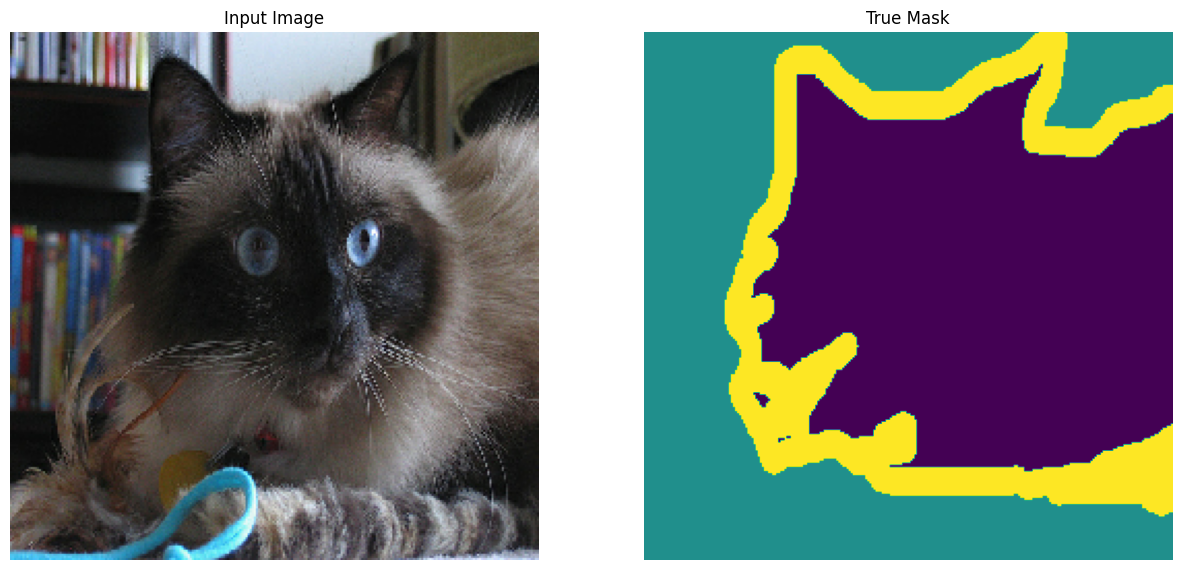

In [57]:
sample_batch = next(iter(train_batches))
random_index = np.random.choice(sample_batch[0].shape[0])
sample_image, sample_mask = sample_batch[0][random_index], sample_batch[1][random_index]
display([sample_image, sample_mask])


## U-net-like architecture

In [58]:
def get_unet_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        x = keras.layers.UpSampling2D(2)(x)

        # Project residual
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = keras.layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(
        x
    )

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


In [59]:
model = get_unet_model(img_size=(HEIGHT, WIDTH), num_classes=NUM_CLASSES)


In [60]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 32  128        ['conv2d_9[0][0]']               
 ormalization)                  )                                                           

In [61]:
for i, layer in enumerate(model.layers):
    print(i, layer.name, layer.trainable)


0 input_2 True
1 conv2d_9 True
2 batch_normalization_15 True
3 activation_15 True
4 activation_16 True
5 separable_conv2d_6 True
6 batch_normalization_16 True
7 activation_17 True
8 separable_conv2d_7 True
9 batch_normalization_17 True
10 max_pooling2d_3 True
11 conv2d_10 True
12 add_7 True
13 activation_18 True
14 separable_conv2d_8 True
15 batch_normalization_18 True
16 activation_19 True
17 separable_conv2d_9 True
18 batch_normalization_19 True
19 max_pooling2d_4 True
20 conv2d_11 True
21 add_8 True
22 activation_20 True
23 separable_conv2d_10 True
24 batch_normalization_20 True
25 activation_21 True
26 separable_conv2d_11 True
27 batch_normalization_21 True
28 max_pooling2d_5 True
29 conv2d_12 True
30 add_9 True
31 activation_22 True
32 conv2d_transpose_8 True
33 batch_normalization_22 True
34 activation_23 True
35 conv2d_transpose_9 True
36 batch_normalization_23 True
37 up_sampling2d_9 True
38 up_sampling2d_8 True
39 conv2d_13 True
40 add_10 True
41 activation_24 True
42 conv2d_t

In [62]:
# plot_model(
#     model,
#     to_file=f'{RESOURCES_DIR}model.png',
#     show_shapes=True,
#     show_layer_names=True,
#     rankdir='TB'
# )


## Training & Testing

In [63]:
optimizer = Adam(learning_rate=1e-5)
# optimizer = SGD(learning_rate=1e-5)

model.compile(
    optimizer=optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


In [64]:
model_checkpointer = ModelCheckpoint(
    f'{RESOURCES_DIR}{MODEL_NAME}.h5',
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='max'
)
store_history = CSVLogger(f'{RESOURCES_DIR}{MODEL_NAME}.csv', append=True)
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    mode='auto',
    verbose=1,
    patience=100
)

start_time = time.perf_counter()
with tf.device('/gpu:0'):
    model_history = model.fit(
        train_batches,
        epochs=NUM_EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VALIDATION_STEPS,
        validation_data=validation_batches,
        verbose=1,

        callbacks=[
            model_checkpointer,
            store_history
            # early_stopping
        ]
    )
end_time = time.perf_counter()


Epoch 1/20
57/57 [==============================] - ETA: 0s - loss: 1.5913 - accuracy: 0.5582
Epoch 1: val_accuracy improved from -inf to 0.53613, saving model to /content/resources/raw_unet.h5
57/57 [==============================] - 67s 1s/step - loss: 1.5913 - accuracy: 0.5582 - val_loss: 0.9797 - val_accuracy: 0.5361
Epoch 2/20
57/57 [==============================] - ETA: 0s - loss: 1.1515 - accuracy: 0.6315
Epoch 2: val_accuracy improved from 0.53613 to 0.56416, saving model to /content/resources/raw_unet.h5
57/57 [==============================] - 50s 878ms/step - loss: 1.1515 - accuracy: 0.6315 - val_loss: 1.3135 - val_accuracy: 0.5642
Epoch 3/20
57/57 [==============================] - ETA: 0s - loss: 1.0120 - accuracy: 0.6541
Epoch 3: val_accuracy improved from 0.56416 to 0.56771, saving model to /content/resources/raw_unet.h5
57/57 [==============================] - 47s 833ms/step - loss: 1.0120 - accuracy: 0.6541 - val_loss: 1.7906 - val_accuracy: 0.5677
Epoch 4/20
57/57 [=

In [65]:
print(f'Time to train: {str("{0:.2f}".format((end_time - start_time) / 60))}')


Time to train: 16.41


In [66]:
model.save(f'{RESOURCES_DIR}{MODEL_NAME}_last_epoch.h5')
model_json = model.to_json()
with open(f'{RESOURCES_DIR}{MODEL_NAME}.json', "w") as json_file:
    json_file.write(model_json)


In [67]:
loss, accuracy = model.evaluate(test_batches, verbose=1)
print("Loss:", loss)
print("Accuracy: %.2f%%" % (accuracy * 100))


11/11 [==============================] - 27s 622ms/step - loss: 0.6227 - accuracy: 0.7539
Loss: 0.6226550936698914
Accuracy: 75.39%


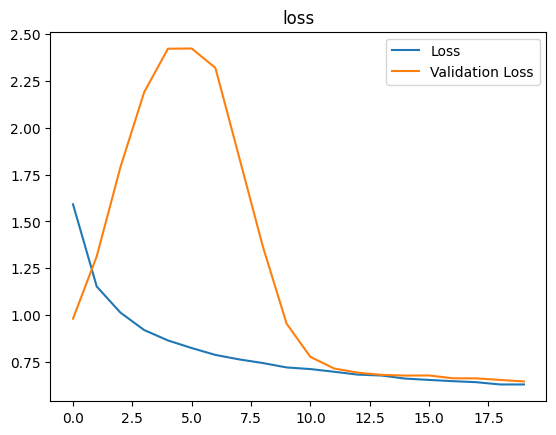

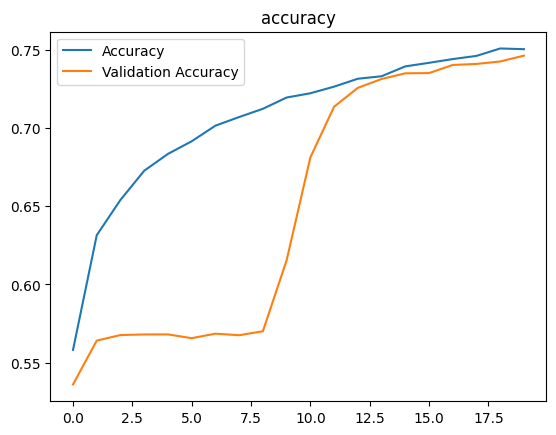

In [71]:
if isinstance(model_history, pd.DataFrame):
    plt.plot(model_history['loss'])
    plt.plot(model_history['val_loss'])
    plt.legend(['train', 'test'])
    plt.title('loss')
    plt.legend(["Loss", "Validation Loss"])
    plt.savefig("loss.png", dpi=300, format="png")
    plt.figure()
    plt.plot(model_history["accuracy"])
    plt.plot(model_history['val_accuracy'])
    plt.legend(['train', 'test'])
    plt.title('accuracy')

else:
    plt.plot(model_history.history['loss'])
    plt.plot(model_history.history['val_loss'])
    plt.legend(['train', 'test'])
    plt.title('loss')
    plt.legend(["Loss", "Validation Loss"])
    plt.savefig("loss.png", dpi=300, format="png")
    plt.figure()
    plt.plot(model_history.history["accuracy"])
    plt.plot(model_history.history['val_accuracy'])
    plt.legend(['train', 'test'])
    plt.title('accuracy')

plt.legend(["Accuracy", "Validation Accuracy"])
plt.savefig("accuracy.png", dpi=300, format="png")


## Prediction

In [72]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]


In [73]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
                 create_mask(model.predict(sample_image[tf.newaxis, ...]))])


2/2 [==============================] - 1s 105ms/step


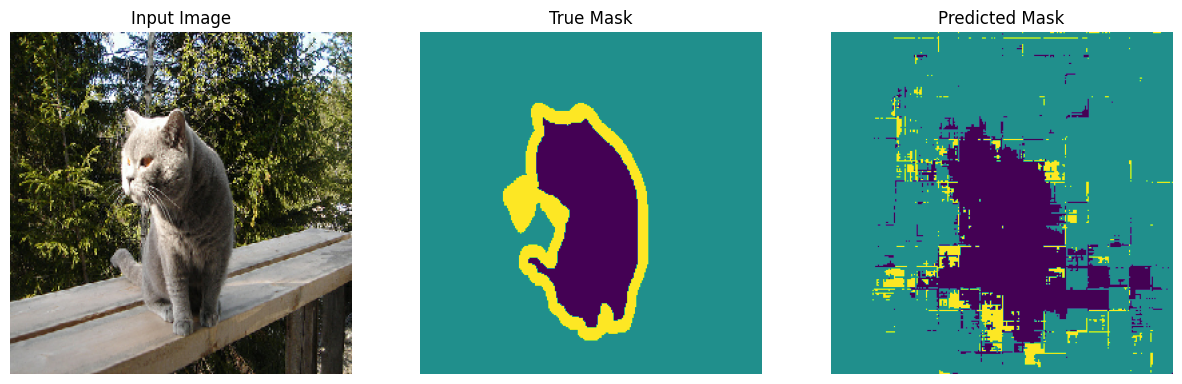

2/2 [==============================] - 0s 115ms/step


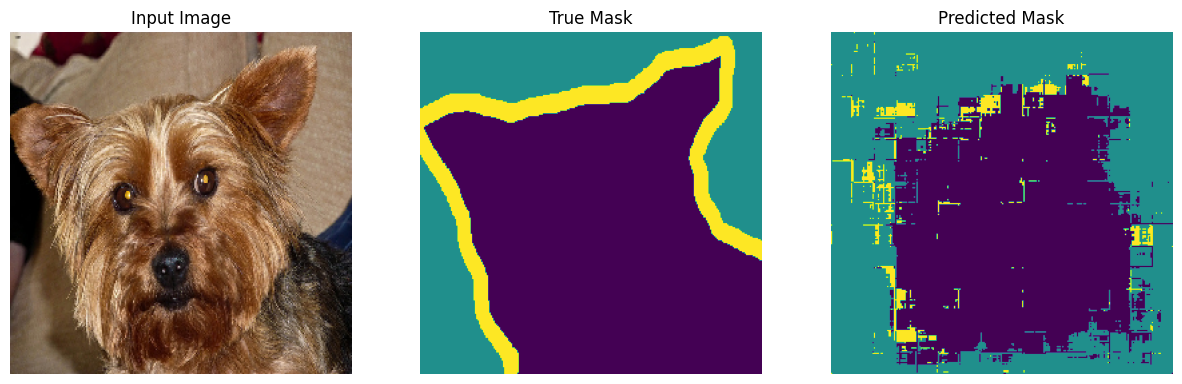

2/2 [==============================] - 0s 119ms/step


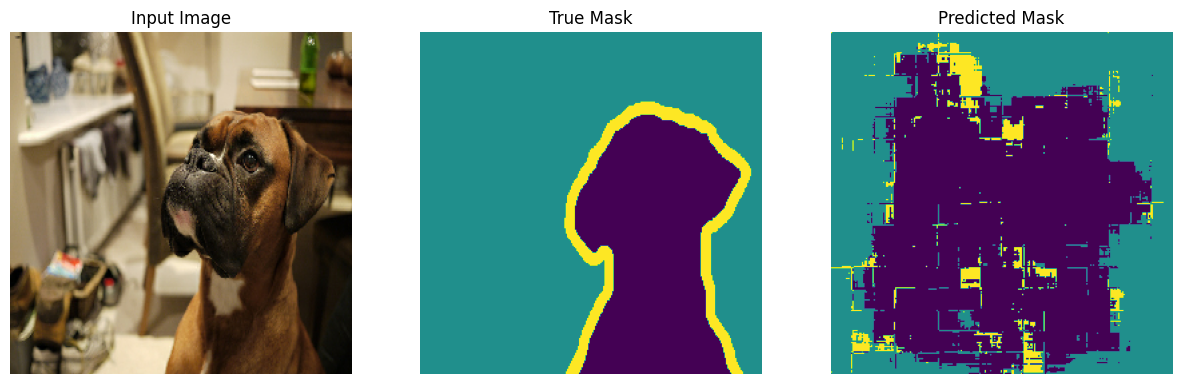

In [74]:
show_predictions(test_batches.skip(5), 3)
